In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import random
from google.colab import drive 
from sklearn.model_selection import train_test_split
import seaborn as sns
import librosa
import librosa.display
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from google.colab import drive 
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

from keras_preprocessing.sequence import pad_sequences
!pip install -q -U keras-tuner
import keras_tuner as kt
import pickle
drive.mount('/content/drive')

import os

     |████████████████████████████████| 135 kB 5.9 MB/s 
     |████████████████████████████████| 1.6 MB 50.9 MB/s 
Mounted at /content/drive


In [2]:
DRIVE_FOLDER = '/content/drive/My Drive/data/false/'
entries = [entry for entry in os.listdir(DRIVE_FOLDER) if os.path.isfile(os.path.join(DRIVE_FOLDER, entry))]
false_dict = {'name':[]}
for file in entries:

    false_dict['name'].append(file)
DRIVE_FOLDER = '/content/drive/My Drive/data/true/'
entries = [entry for entry in os.listdir(DRIVE_FOLDER) if os.path.isfile(os.path.join(DRIVE_FOLDER, entry))]
true_dict = {'name':[]}
for file in entries:

    true_dict['name'].append(file)

In [4]:
df1 = pd.DataFrame(false_dict)
df1['label'] = 0
df1['path'] = '/content/drive/My Drive/data/false/'
print('The number of false labels is: ', df1.shape[0])
df2 = pd.DataFrame(true_dict)
df2['label'] = 1
df2['path'] = '/content/drive/My Drive/data/true/'
print('The number of true labels is: ', df2.shape[0])
# combine both dataframes
df = pd.concat([df1,df2])
df = df.sample(frac=1, random_state=56).reset_index(drop=True)

print('The length of the dataset is: ', f'{df.shape[0]:,}')

labels = df['label'].unique()
print(df.head)

The number of false labels is:  826
The number of true labels is:  826
The length of the dataset is:  1,652
<bound method NDFrame.head of                        name  label                                 path
0     Mani_false188 (1).wav      0  /content/drive/My Drive/data/false/
1     Mani_false237 (1).wav      0  /content/drive/My Drive/data/false/
2               Mani259.wav      1   /content/drive/My Drive/data/true/
3         Mani_false248.wav      0  /content/drive/My Drive/data/false/
4         Mani_false493.wav      0  /content/drive/My Drive/data/false/
...                     ...    ...                                  ...
1647            Mani658.wav      1   /content/drive/My Drive/data/true/
1648        Maninoise73.wav      1   /content/drive/My Drive/data/true/
1649        Mani644 (1).wav      1   /content/drive/My Drive/data/true/
1650      Mani_false319.wav      0  /content/drive/My Drive/data/false/
1651      Mani_false395.wav      0  /content/drive/My Drive/data/false

In [5]:
n_mfccs = 128

max_len= 300
def get_features(df_in):
    features=[] #list to save features
    labels=[] #list to save labels
    for i in tqdm(range(0,df_in.shape[0])):
    
      y , sr = librosa.load(df_in.iloc[i][2] + df_in.iloc[i][0])
 
    
      mfccs = librosa.feature.mfcc(y, sr = sr, n_mfcc=n_mfccs, hop_length = max_len)
      # If maximum length exceeds mfcc lengths then pad the remaining ones
      if (max_len > mfccs.shape[1]):
        pad_width = max_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')

      # Else cutoff the remaining parts
      else:
        mfccs = mfccs[:, :max_len]
      mfccs = np.array(mfccs)
      features.append(mfccs)
      labels.append(df_in.iloc[i][1])
 
    output=np.concatenate(features,axis=0)

    return(np.array(features), labels)
X,y=get_features(df)

  0%|          | 0/1652 [00:00<?, ?it/s]

In [6]:
#Split twice to get the validation set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=125, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=125)

X_train.shape, X_test.shape,len(y_train), len(y_test)

((1193, 128, 300), (248, 128, 300), 1193, 248)

In [7]:
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train.reshape(X_train.shape[0], -1)).reshape(X_train.shape)
X_val = sc.transform(X_val.reshape(X_val.shape[0], -1)).reshape(X_val.shape)
X_test = sc.transform(X_test.reshape(X_test.shape[0], -1)).reshape(X_test.shape)
print(X_train.shape,X_test.shape)
X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

(1193, 128, 300) (248, 128, 300)


In [8]:
import keras
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import load_model
tf.random.set_seed(12345)

In [9]:


model_dir = '/content/drive/MyDrive/Spotify/trained_models/LSTM_model_history.h5'
checkpoint = ModelCheckpoint(model_dir, monitor='val_binary_accuracy', verbose=1, save_best_only=True, mode='max')

model = tf.keras.Sequential()
model.add(LSTM(64,input_shape=(n_mfccs, max_len), return_sequences=True))
model.add(Activation('relu'))

model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Activation('relu'))

model.add(Dense(192))
model.add(Activation('relu'))

model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(loss= 'binary_crossentropy', optimizer= Adam(learning_rate=0.00001),metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.AUC()])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128, 64)           93440     
                                                                 
 activation (Activation)     (None, 128, 64)           0         
                                                                 
 dropout (Dropout)           (None, 128, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 activation_1 (Activation)   (None, 32)                0         
                                                                 
 dense (Dense)               (None, 192)               6336      
                                                                 
 activation_2 (Activation)   (None, 192)               0

In [10]:
batch_size= 20
epochs= 50

In [11]:
history = model.fit(X_train,y_train,epochs=epochs,validation_data = (X_val, y_val), batch_size=batch_size,verbose=1, callbacks=[checkpoint])

Epoch 1/50
59/60 [============================>.] - ETA: 0s - loss: 0.6926 - binary_accuracy: 0.5254 - auc: 0.5378
Epoch 1: val_binary_accuracy improved from -inf to 0.57346, saving model to /content/drive/MyDrive/Spotify/trained_models/LSTM_model_history.h5
60/60 [==============================] - 13s 50ms/step - loss: 0.6926 - binary_accuracy: 0.5256 - auc: 0.5405 - val_loss: 0.6921 - val_binary_accuracy: 0.5735 - val_auc: 0.5902
Epoch 2/50
59/60 [============================>.] - ETA: 0s - loss: 0.6917 - binary_accuracy: 0.5678 - auc: 0.5917
Epoch 2: val_binary_accuracy improved from 0.57346 to 0.60190, saving model to /content/drive/MyDrive/Spotify/trained_models/LSTM_model_history.h5
60/60 [==============================] - 2s 29ms/step - loss: 0.6917 - binary_accuracy: 0.5666 - auc: 0.5903 - val_loss: 0.6916 - val_binary_accuracy: 0.6019 - val_auc: 0.6224
Epoch 3/50
58/60 [============================>.] - ETA: 0s - loss: 0.6915 - binary_accuracy: 0.5534 - auc: 0.5926
Epoch 3: va

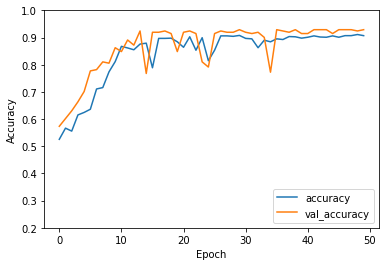

In [12]:
plt.plot(history.history['binary_accuracy'], label='accuracy')
plt.plot(history.history['val_binary_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.2, 1])
plt.legend(loc='lower right')

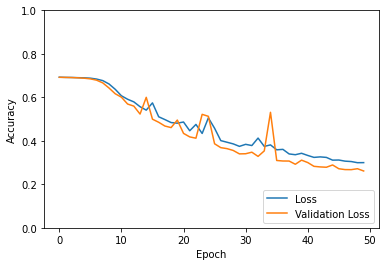

In [13]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1])
plt.legend(loc='lower right')

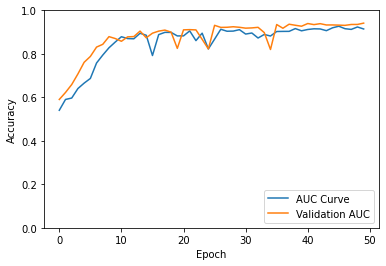

In [14]:
plt.plot(history.history['auc'], label='AUC Curve')
plt.plot(history.history['val_auc'], label = 'Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1])
plt.legend(loc='lower right')

In [15]:
model_saved = load_model('/content/drive/MyDrive/Spotify/trained_models/LSTM_model_history.h5')

In [16]:
#predict

y_pred = model_saved.predict(X_test, batch_size = batch_size, verbose=1)
y_pred = (y_pred > 0.5).astype('int')

13/13 [==============================] - 1s 9ms/step


In [17]:
#Accuracy from Keras
loss, acc, auc = model_saved.evaluate(X_test, y_test, verbose=1, batch_size = batch_size)
print('Accuracy', "{:.2%}".format(acc))

13/13 [==============================] - 1s 11ms/step - loss: 0.3225 - binary_accuracy: 0.9435 - auc: 0.9473
Accuracy 94.35%


Accuracy Score is : 94.35%
 
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.90      0.94       124
           1       0.90      0.99      0.95       124

    accuracy                           0.94       248
   macro avg       0.95      0.94      0.94       248
weighted avg       0.95      0.94      0.94       248

 


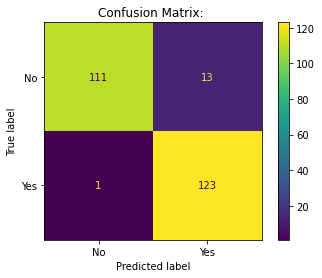

In [18]:
accuracy = accuracy_score(y_test, y_pred) 
print("Accuracy Score is : " + "{:.2%}".format(accuracy))
print(' ')
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
    
disp.plot()
plt.title('Confusion Matrix: ')

print("Classification Report:")
print(classification_report(y_test, y_pred, labels=[0, 1], zero_division=1))
print(" ")
plt.show()

In [19]:
scalerfile = 'LSTM_scaler.sav'
pickle.dump(sc, open('/content/drive/MyDrive/Spotify/trained_models/'+scalerfile, 'wb'))